# Predicting alpacas

In this exercise we use a pretrained MobileNetV2 model to predict whether an image contains an alpaca or not.

First unzip the provided data. The data comes with two subfolders, each folder containing the data for one class. For image data structured this way, TensorFlow has a dedicated function for loading the data: [image_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory)

You need to provide:
- `directory=`: the "data" subfolder
- `batch_size=`: the data is directly read into batches and this gives you the size of one batch (we will use 32)
- `image_size=`: the target dimensions of our images - each image will be scaled to this size (we will use 160x160)
- `shuffle=`: Set this to `True` so that all we do get images randomly mixed from all classes
- `validation_split=` The amount of images that should be kept for validation (in our case 20%)

The function yields one dataset but has the functionality to directly extract a validation set. You need to call the function twice to get the training and the validation set respectively. Using either `subset='training'` or `subset='validation'` you can determine which set should be returned. To make sure that you get matching subsets (and have no overlap between training and validation data), provide `seed=` with a certain seed that is the same in both calls.

In [1]:
import os
# Disable GPU usage (GPUs add no value for the small example and we do not need to fight for ressources this way) 
os.environ["CUDA_VISIBLE_DEVICES"]="-1"
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory


BATCH_SIZE = 32
SIZE = 160
IMG_SIZE = (SIZE, SIZE)

train_dataset = image_dataset_from_directory(
    directory="./data",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True,
    validation_split=0.2,
    subset="training",
    seed=1)
validation_dataset = image_dataset_from_directory(
    directory="./data",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True,
    validation_split=0.2,
    subset="validation",
    seed=1)

Found 205 files belonging to 10 classes.
Using 164 files for training.
Found 205 files belonging to 10 classes.
Using 41 files for validation.


2023-01-06 06:50:21.650593: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-01-06 06:50:21.650661: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: 8ed85119e3ed
2023-01-06 06:50:21.650679: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: 8ed85119e3ed
2023-01-06 06:50:21.650846: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 515.43.4
2023-01-06 06:50:21.650891: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.43.4
2023-01-06 06:50:21.650906: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 515.43.4
2023-01-06 06:50:21.651389: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instruct

You can now inspect the format of the loaded data:

In [2]:
train_dataset.element_spec

(TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [3]:
for x, y in train_dataset:
    print(x.shape)
    print(y)
    break

(32, 160, 160, 3)
tf.Tensor([9 4 3 5 3 1 0 6 9 6 1 4 1 4 6 6 9 4 8 9 1 9 6 2 2 4 6 5 5 3 0 3], shape=(32,), dtype=int32)


The dataset remembers names for each label which it takes from the corresponding sub folders.

In [4]:
train_dataset.class_names

['0', '10', '20', '30', '40', '50', '60', '70', '80', '90']

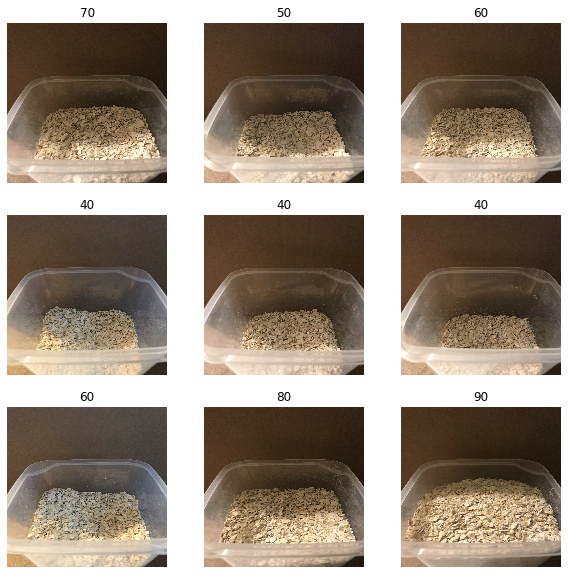

In [5]:
import matplotlib.pyplot as plt

class_names = train_dataset.class_names

# Plot 9 examples from the training set

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

## MobileNetV2

We will use MobileNetV2 as the basis for our model. Tensorflow comes with many common architectures already pre implemented and with downloadable weights.

Using [tf.keras.applications.MobileNetV2](https://www.tensorflow.org/api_docs/python/tf/keras/applications/mobilenet_v2/MobileNetV2) you can easily setup a MobileNetV2 model.
You should provide:
- `input_shape=`: The model has support for different input sizes. Our images are 160x160 with 3 color channels.
- `include_top=`: For now we will set this to true so that we a full model. Later we will remove the top layers and replace them with our own ones.
- `weights=`: By specifying `'imagenet'` we tell tensorflow to download weights for the model, trained on the ImageNet dataset.


In [6]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(160, 160, 3),
    include_top=True #,
    #weights="imagenet"
)

We can now look at the model and all its 156 layers:

In [7]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

## MobileNet predictions

We can directly use the model to make predictions for our images. With `base_model(data)` you can simply apply the model to a batch of images.
But first there is an important thing to remember: the MobileNetV2 was trained with scaled input data. In general, when using a pretrained model we need to make sure that we preprocess our data in the same way. Using [tf.keras.applications.mobilenet_v2.preprocess_input](https://www.tensorflow.org/api_docs/python/tf/keras/applications/mobilenet_v2/preprocess_input) you can apply the required preprocessing steps to a batch of images. Then apply the model to the preprocessed data.

In [8]:
image_batch, label_batch = next(iter(train_dataset))

preprocessed = tf.keras.applications.mobilenet_v2.preprocess_input(image_batch)
predictions = base_model(preprocessed)

print(predictions.shape)

(32, 1000)


We want to translate these predictions into the original class names. The function [tf.keras.applications.mobilenet_v2.decode_predictions](https://www.tensorflow.org/api_docs/python/tf/keras/applications/mobilenet_v2/decode_predictions) can be used to get get these.

In [9]:
decoded_preds = tf.keras.applications.mobilenet_v2.decode_predictions(predictions.numpy(), top=3)
decoded_preds

[[('n03775546', 'mixing_bowl', 0.2998436),
  ('n04476259', 'tray', 0.13863873),
  ('n07860988', 'dough', 0.121982716)],
 [('n02808440', 'bathtub', 0.757902),
  ('n04493381', 'tub', 0.1987291),
  ('n04553703', 'washbasin', 0.011386455)],
 [('n04493381', 'tub', 0.3506732),
  ('n02808440', 'bathtub', 0.295709),
  ('n03775546', 'mixing_bowl', 0.04099998)],
 [('n04493381', 'tub', 0.27535498),
  ('n02808440', 'bathtub', 0.18788935),
  ('n04476259', 'tray', 0.04696369)],
 [('n04476259', 'tray', 0.8868503),
  ('n02747177', 'ashcan', 0.011739964),
  ('n04493381', 'tub', 0.009807577)],
 [('n02808440', 'bathtub', 0.67761064),
  ('n04493381', 'tub', 0.09189071),
  ('n04553703', 'washbasin', 0.025033763)],
 [('n04476259', 'tray', 0.5935931),
  ('n03775546', 'mixing_bowl', 0.07903747),
  ('n07860988', 'dough', 0.051214475)],
 [('n02808440', 'bathtub', 0.47018573),
  ('n04553703', 'washbasin', 0.17560712),
  ('n04493381', 'tub', 0.13801378)],
 [('n04476259', 'tray', 0.6564487),
  ('n04493381', 'tub',

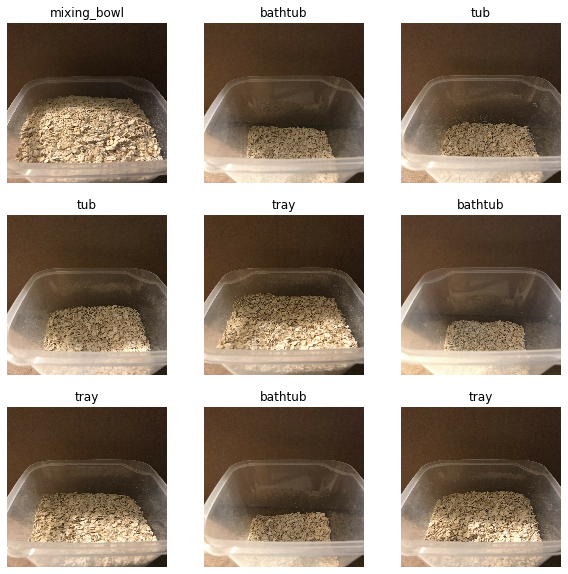

In [10]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(decoded_preds[i][0][1])
        plt.axis("off")

## Data augmentation

As "alpaca" was no class in the original ImageNet dataset, the closest we get is "llama". We now want to adapt the model to our dataset.
In order to get the most out of our limited data we want to use data augmentation. TensorFlow has several data augmentation operations already implemented as Keras layers. As they work like any other Keras layer we can now create a Sequential model out of several of these.
We want to use:

- `RandomFlip` (it should be sufficient to specify only a horizontal flip - in production we would not expect images that are taken upside down)
- `RandomRotation` (again a rotation of not more than 20% of a full rotation should be enough)
- `RandomContrast` (20% for the contrast factor might be reasonable)
- `RandomZoom` (30% zooming in or out should be enough)

In [11]:
import tensorflow.keras.layers as tfl

data_augmenter = tf.keras.Sequential([
    tfl.RandomFlip("horizontal"),
    tfl.RandomRotation(0.001),
    tfl.RandomContrast(0.2),
    tfl.RandomZoom(0.1)
])

Now we can see different versions created from the augmenter for a single image.

Note that the augmenter is called with the flag `training=True`. Similar to a dropout layer we only want toe use the data augmentation during training. So it is switched off by default and only used during training.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


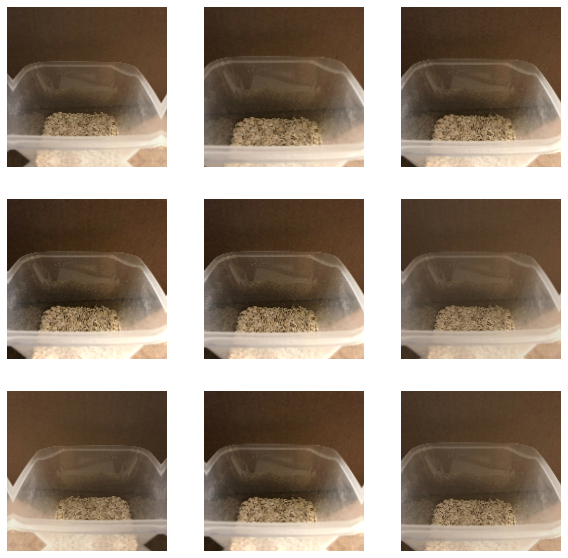

In [12]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmenter(tf.expand_dims(first_image, 0), training=True)
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

## Create a modified version of MobileNetV2

Now we create and train a modified version of the MobileNet model.
We will again use a pretrained MobileNetV2. This time set `include_top` to `False` as we want to create our own output layer.

On the loaded model, set the `.trainable` flag to false. This signals TensorFlow, that all parameters of the model will be frozen and not changed during training.

Print the summary of the model.

In [13]:
input_shape = IMG_SIZE + (3,)

base_model = tf.keras.applications.MobileNetV2(
    input_shape=input_shape,
    include_top=False,
    weights="imagenet"
)

base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_2[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

If look at the models summary you will see that, compared to the previous model, this one now has two less layers at the end. The last `GlobalAveragePooling2D` was also considered one of the "top" layers by the model authors. For our model we should consider adding it again.

Configuring our model does not work well with the Keras Sequential Model API (even though we will create a simple sequential model.

Using the functional API is not much more complicated than the Sequential API. You basically specify an input layer as `tf.keras.Input` with a given input shape. Then you apply a layer to the input giving you the layers activations. These can then be used as input to the next layer until arriving at the final outputs.

Using `tf.keras.Model(inputs, outputs)` we can then specify the entire model and TensorFlow will figure out what steps we used to get from inputs to outputs.

In [14]:
inputs = tf.keras.Input(shape=input_shape)

# Apply the data_augmenter to the inputs
augmented = data_augmenter(inputs)

# Use the MobileNetV2 preprocessing step
preprocessed = tf.keras.applications.mobilenet_v2.preprocess_input(augmented)

# Apply the base model
base_applied = base_model(preprocessed)

# Add a GlobalAveragePooling2D layer
pooled = tfl.GlobalAvgPool2D()(base_applied)

# Add a Dropout layer with probability 20%
dropout = tfl.Dropout(0.2)(pooled)

# Add a Dense layer with a single output
outputs = tfl.Dense(1)(dropout)

model = tf.keras.Model(inputs, outputs)

Again we can print out a model summary. Note that this only includes the steps we added. The MobileNet part is shown as a single step here.
The data augmentation steps are also left out in the summary (as they only apply during training).

In [15]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

Now compile the model with the Adam optimizer (learning_rate 0.001), the BinaryCrossentropy loss (from_logits=True) and the accuracy metric.

In [16]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=["accuracy"])

Now we can train the model for 10 epochs and plot how the loss and the accuracy develop. By providing `validation_data`, TensorFlow will report metrics on the validation set for each epoch.

In [17]:
history = model.fit(train_dataset, validation_data=validation_dataset, epochs=10)

Epoch 1/10
6/6 [==============================] - 12s 741ms/step - loss: -4.5281 - accuracy: 0.1159 - val_loss: -13.2112 - val_accuracy: 0.1220
Epoch 2/10
6/6 [==============================] - 9s 629ms/step - loss: -18.1086 - accuracy: 0.0854 - val_loss: -25.0459 - val_accuracy: 0.1220
Epoch 3/10
6/6 [==============================] - 9s 677ms/step - loss: -30.6729 - accuracy: 0.0854 - val_loss: -36.7136 - val_accuracy: 0.1220
Epoch 4/10
6/6 [==============================] - 9s 637ms/step - loss: -43.2455 - accuracy: 0.0854 - val_loss: -48.4795 - val_accuracy: 0.1220
Epoch 5/10
6/6 [==============================] - 9s 657ms/step - loss: -55.5565 - accuracy: 0.0854 - val_loss: -60.5967 - val_accuracy: 0.1220
Epoch 6/10
6/6 [==============================] - 9s 661ms/step - loss: -68.9331 - accuracy: 0.0854 - val_loss: -72.6107 - val_accuracy: 0.1220
Epoch 7/10
6/6 [==============================] - 9s 640ms/step - loss: -83.1628 - accuracy: 0.0854 - val_loss: -84.3069 - val_accuracy:

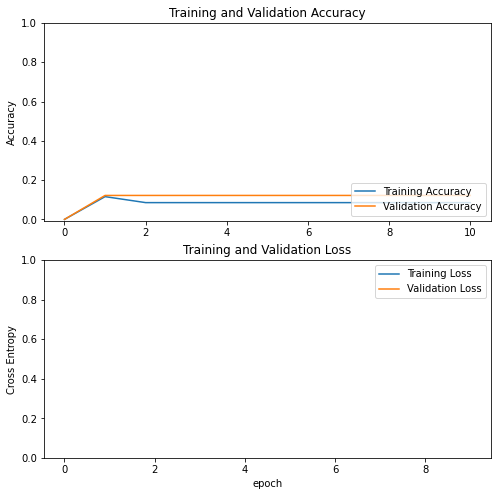

In [18]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Finetuning the model

Next we want to improve the model further by finetuning some more of the layers. We do not want to adjust all the parameters but only those of some of the last few layers (as earlier layers represent more low level features we expect those to be more reusable for other applications).

We have access to each layer of the MobileNet model with `base_model.layers`. This way you can count all the layers:

In [19]:
len(base_model.layers)

154

Now you need to set the `.trainable` flag of the entire model to `True`. We want to keep the weights of the first 120 layers frozen. To do so iterate over those layers and set the `.trainable` flag on them to `False` individually.

Then compile the model again but set the learning rate to 0.0001. (The more layers we want to adjust, the more carful we have to step to not mess everything up again)

In [20]:
base_model.trainable = True

for i in range(120):
    base_model.layers[i].trainable = False
    
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

Now we can continue training. As you can see, you can specify an `initial_epoch` to get a continuous training history for the model.

In [21]:
history_fine = model.fit(train_dataset,
                         epochs=20,
                         initial_epoch=history.epoch[-1]+1,
                         validation_data=validation_dataset)

Epoch 11/20
6/6 [==============================] - 12s 822ms/step - loss: -104.4410 - accuracy: 0.0854 - val_loss: -134.6437 - val_accuracy: 0.1220
Epoch 12/20
6/6 [==============================] - 9s 742ms/step - loss: -149.3993 - accuracy: 0.0854 - val_loss: -159.8769 - val_accuracy: 0.1220
Epoch 13/20
6/6 [==============================] - 9s 721ms/step - loss: -192.6409 - accuracy: 0.0854 - val_loss: -208.6335 - val_accuracy: 0.1220
Epoch 14/20
6/6 [==============================] - 9s 735ms/step - loss: -227.5306 - accuracy: 0.1341 - val_loss: -284.5631 - val_accuracy: 0.1220
Epoch 15/20
6/6 [==============================] - 9s 729ms/step - loss: -251.6954 - accuracy: 0.1037 - val_loss: -378.7838 - val_accuracy: 0.0732
Epoch 16/20
6/6 [==============================] - 9s 740ms/step - loss: -296.8954 - accuracy: 0.0976 - val_loss: -487.9424 - val_accuracy: 0.0732
Epoch 17/20
6/6 [==============================] - 9s 723ms/step - loss: -313.4742 - accuracy: 0.0976 - val_loss: -56

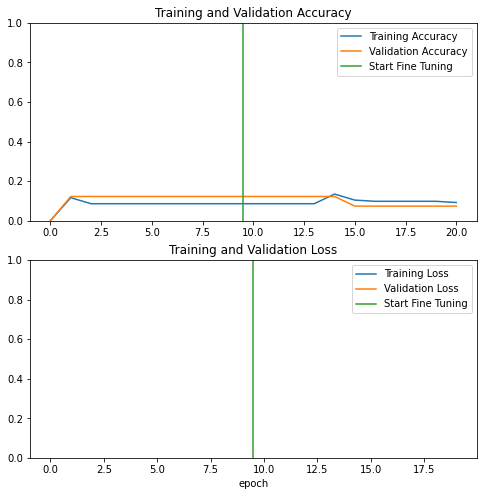

In [22]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([history.epoch[-1]+0.5,history.epoch[-1]+0.5],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([history.epoch[-1]+0.5,history.epoch[-1]+0.5],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

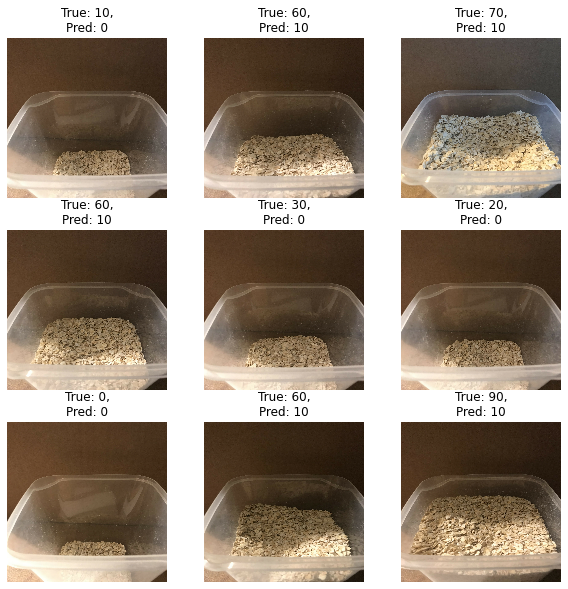

In [23]:
image_batch, label_batch = next(iter(validation_dataset))
predictions = model(image_batch)

class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    prediction = int(predictions[i] >= 0)
    plt.title(f"True: {class_names[label_batch[i]]},\nPred: {class_names[prediction]}")
    plt.axis("off")

## Possible improvements

Think about the next steps you can do to improve the model and discuss them in class.